Bryan Jay - 260738764

## 2 - Stereo Vision

##### Q2.1 Depth Estimation from Stereo Images

In [122]:
import sys
import re
from struct import *
import numpy as np
from matplotlib import pyplot as plt

def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
    return img

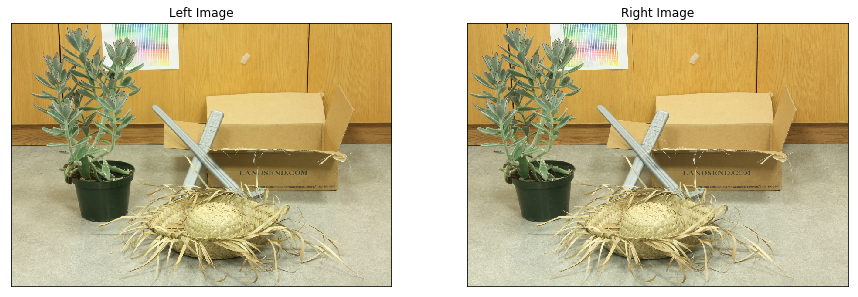

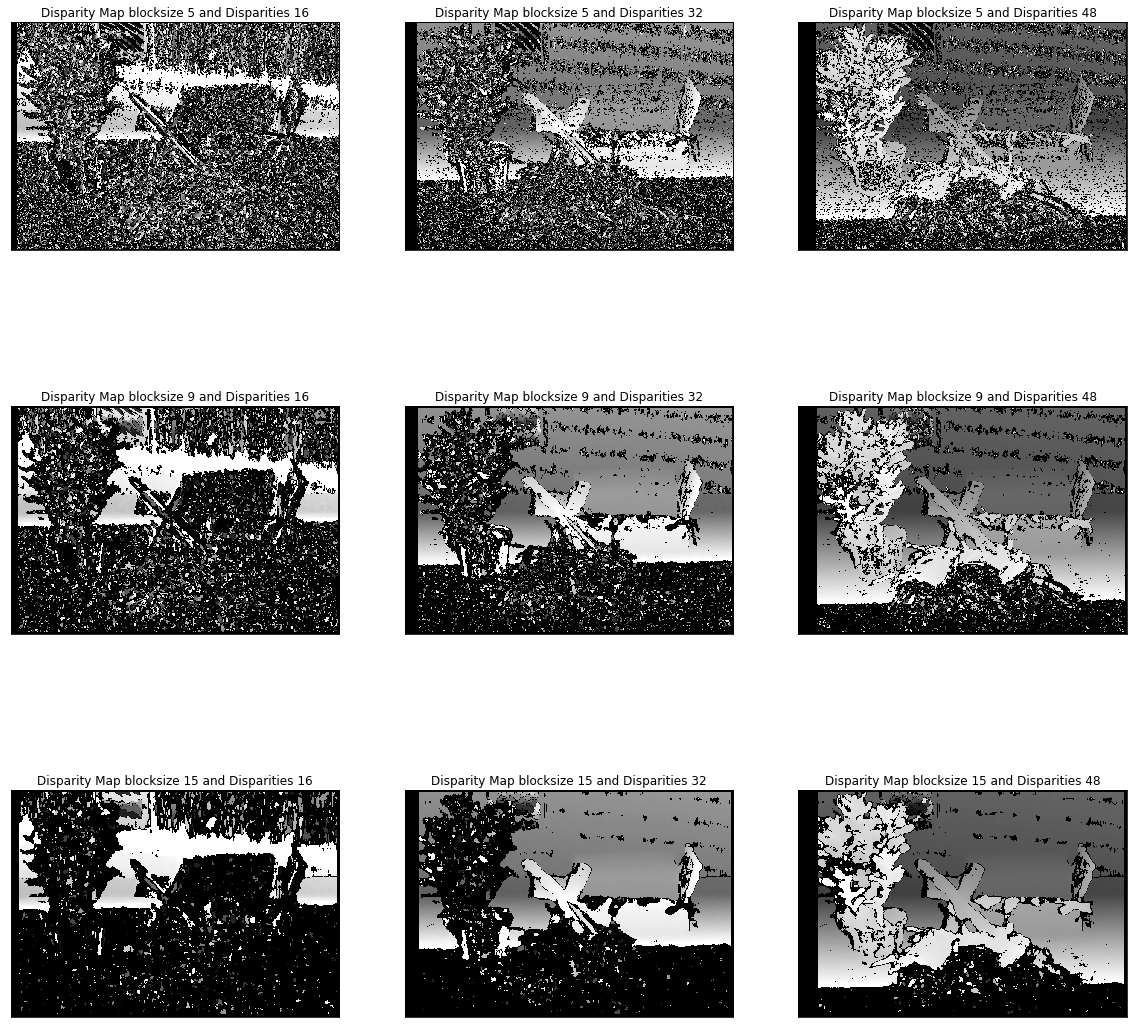

In [123]:
import cv2

# load left and right images 
imgL = cv2.imread('swords0.png')
imgR = cv2.imread('swords1.png')

# resize images to process quicker
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)

imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)

# put all the disparities and block size possibilities into a list
points = [(5, 16), (5, 32), (5, 48), (9, 16), (9, 32), (9, 48), (15, 16), (15, 32), (15, 48)]

disparity = list()
# compute disparity map for the 9 diagrams
for point in points:
    stereo = cv2.StereoBM_create(numDisparities=point[1], blockSize=point[0])
    disparity.append(stereo.compute(imgL_gray, imgR_gray))
    
# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
for i in range(len(points)):
    plt.subplot(331+i), plt.imshow(disparity[i], cmap="gray")
    plt.title("Disparity Map blocksize %d and Disparities %d" %points[i]), plt.xticks([]), plt.yticks([])
plt.show()


##### Q2.1 Pixel-Wise Squared difference error 

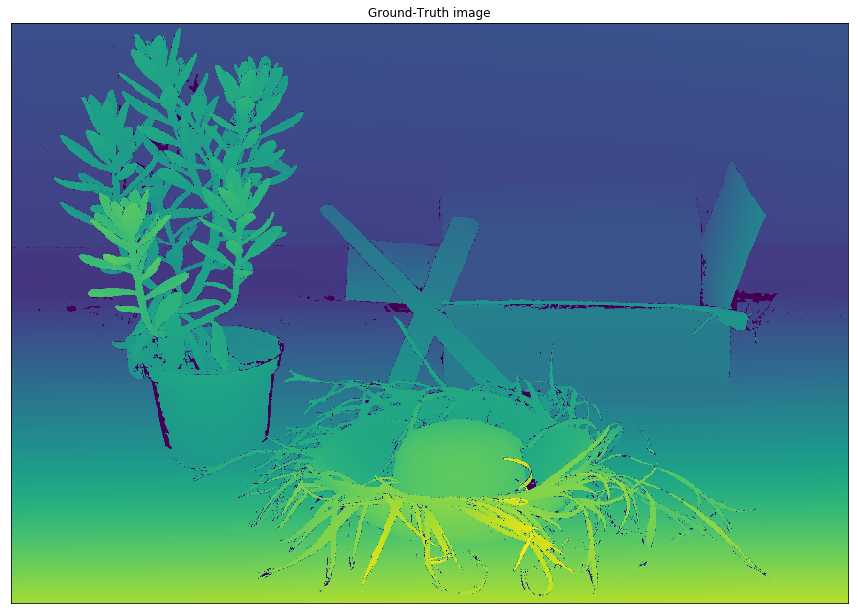

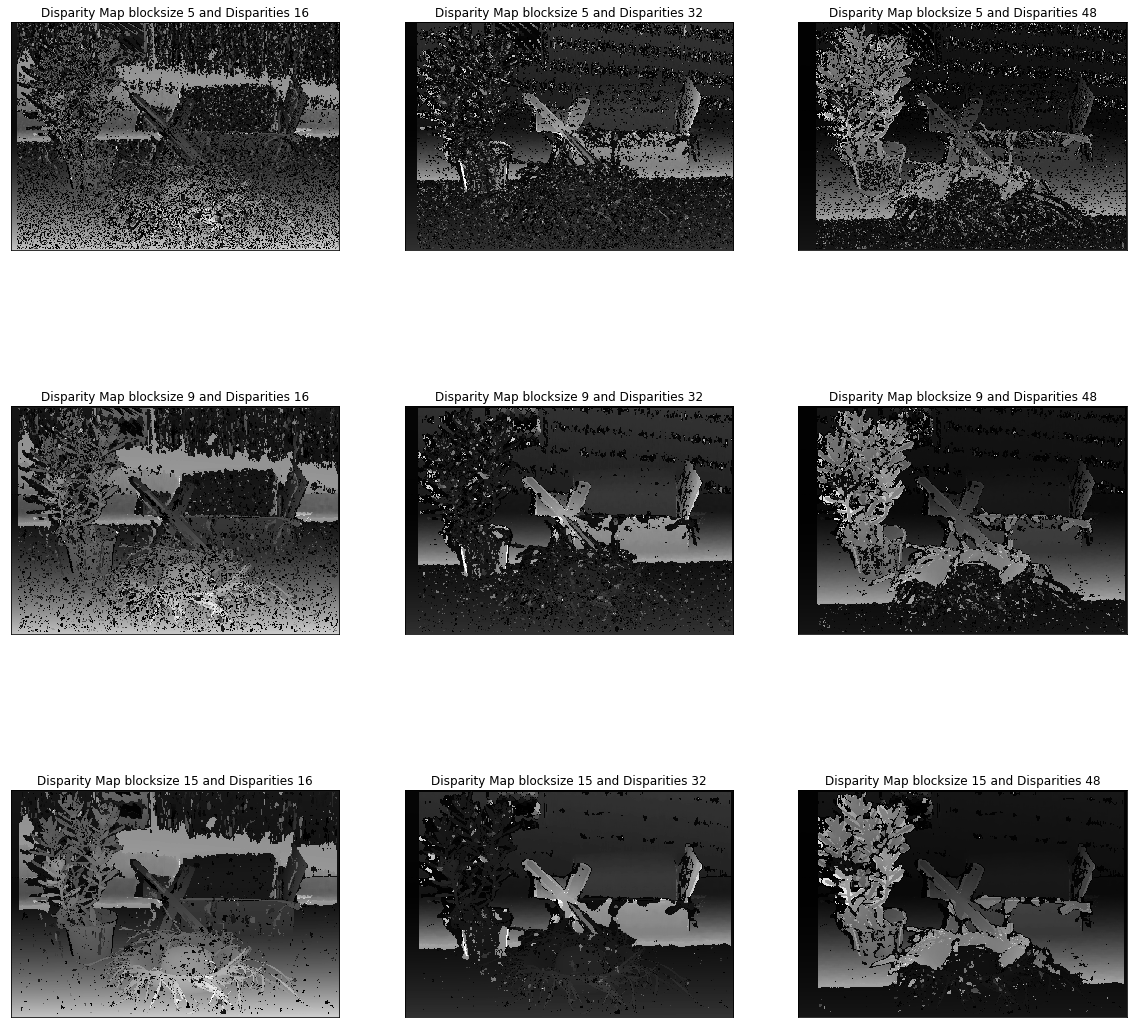

In [126]:
# load left and right images
groundtruth = read_pfm("disp0.pfm")
# groundtruth = read_pfm("disp1.pfm")
groundtruth[groundtruth==np.inf] = 0

# resize the ground truth image
groundtruth = cv2.resize(groundtruth, None, fx=0.3, fy=0.3)

# print(disparity[1].shape)

# mse_map = list()
# for disp in disparity:
#     disp = disparity[0]
#     mse = np.zeros(disp.shape)
#     for x in range(disp.shape[0]):
#         for y in range(disp.shape[1]):
#             d_pixel = disp[x][y]
#             g_pixel = groundtruth[x][y]
#             mse[x][y] = ((d_pixel-g_pixel)**2)
#     mse_map.append(mse)

mse_map = list()
for i in range(9):
    mse_map.append(((disparity[i]-groundtruth)**2))           
        
# print(len(mse_map))
    
plt.figure(figsize=(15,15))
plt.imshow(groundtruth)
plt.title('Ground-Truth image'), plt.xticks([]), plt.yticks([])
    
# print(min(mse))
    
plt.figure(figsize=(20,20))
for i in range(len(points)):
    plt.subplot(331+i), plt.imshow(mse_map[i], cmap="gray")
    plt.title("Disparity Map blocksize %d and Disparities %d" % (points[i]))
    plt.xticks([]), plt.yticks([])
plt.show()

# plt.figure(figsize=(20,20))
# for i in range(len(points)):
#     plt.subplot(331+i), plt.imshow(disparity[i],cmap="gray")
#     plt.title("Disparity Map blocksize %d and Disparities %d\n Mean Squared Difference %d" % (points[i] + (mse[i], )))
#     plt.xticks([]), plt.yticks([])
# plt.show()

##### Comment on the Error-maps

Starting at block size, the increase in blocksize helps to lower the noise around edges. At a higher block size the edges are more defined and are clearly notceable. However is does not aid in displaying points of texture as it smoothes out the objects and it does not differentiate the depth in the image. Therefore when the blocksize is increased too high it smooths out the texture too much.

On the other hand, increase in disparities helps define define the depth of the image and allows to demonstrate where theres are higher depths compared to lower ones. Additionally, it catches points of texture along the the image. For example the plant is an object with a lot of texture and the increase in disparities allow to the the amount of texture to be shown.

Taking a look at the error maps it demonstrates that for the case where we have a block size of 9 and 48 disparities will display the better error map. Looking at the properties of noth the block size and error maps it seems that it's better to have higher disparity but there is a max and min to the blocksize